<p><font size="6"><b>Xarray advanced</b></font></p>


> *DS Python for GIS and Geoscience*  
> *September, 2023*
>
> *© 2023, Joris Van den Bossche and Stijn Van Hoey. Licensed under [CC BY 4.0 Creative Commons](http://creativecommons.org/licenses/by/4.0/)*

---

Acknowledgments to the data service: https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-land-monthly-means?tab=overview

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import cmocean

%matplotlib inline

## `xarray.Dataset` for multiple variables

We already know `xarray.DataArray`, it is a single multi-dimensional array and each dimension can have a name and coordinate values. Next to the `DataArray`, `xarray` has a second main data structure to store arrays, i.e. `xarray.DataSet`. 

Let's read an xarray data set (global rain/temperature coverage stored in the file `2016-2017_global_rain-temperature.nc`), using the function `open_dataset`:

In [2]:
ds = xr.open_dataset("./data/2016-2017_global_rain-temperature.nc", engine="netcdf4")
ds

<xarray.Dataset>
Dimensions:        (y: 347, x: 720, year: 2)
Coordinates:
  * y              (y) float64 83.25 82.75 82.25 81.75 ... -88.75 -89.25 -89.75
  * x              (x) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * year           (year) int64 2016 2017
Data variables:
    precipitation  (year, y, x) float32 ...
    temperature    (year, y, x) float32 ...

<div class="alert alert-info" style="font-size:120%">

**REMEMBER**: <br>

xarray provides reading function for different formats with the `open_dataset` and `open_dataarray` functions. For GIS formats such as geotiff and other GDAL readable raster data, the rasterio engine (`engine="rasterio"`) is available after the installation of [rioxarray](https://corteva.github.io/rioxarray/stable/). NetCDF-alike data formats can also be loaded using the `open_dataset()` function using a NetCDF-compatible engine, e.g. `netcdf` or `h5netcdf`. The netcdf-engine will be _guessed_ by default.

</div>

Let's take a closer look at this `xarray.Dataset`:

- A `xarray.Dataset` is the second main data type provided by xarray
- This example has 3 __dimensions__:
    - `y`: the y coordinates of the data set
    - `x`: the x coordinates of the data set
    - `year`: the year coordinate of the data set
- Each of these dimensions are defined by a __coordinate__ (1D) array
- It has 2 __Data variables__: `precipitation` and `temperature` that both share the same coordinates

Hence, a `Dataset` object stores *multiple* arrays that have shared dimensions (__Note:__ not all dimensions need to be shared).  It is designed as an in-memory representation of the data model from the netCDF file format.

![](http://xarray.pydata.org/en/stable/_images/dataset-diagram.png)

In [3]:
ds["temperature"].shape, ds["temperature"].dims

((2, 347, 720), ('year', 'y', 'x'))

The data and coordinate variables are also contained separately in the `data_vars` and `coords` dictionary-like attributes of a `xarray.DataSet` to access them directly:

- The data variables:

In [4]:
ds.data_vars

Data variables:
    precipitation  (year, y, x) float32 ...
    temperature    (year, y, x) float32 ...

- The data coordinates:

In [5]:
ds.coords

Coordinates:
  * y        (y) float64 83.25 82.75 82.25 81.75 ... -88.25 -88.75 -89.25 -89.75
  * x        (x) float64 -179.8 -179.2 -178.8 -178.2 ... 178.2 178.8 179.2 179.8
  * year     (year) int64 2016 2017

If you rather use an alternative name for a given variable, use the `rename` method:

In [6]:
ds.rename({"precipitation": "rain"})

<xarray.Dataset>
Dimensions:      (y: 347, x: 720, year: 2)
Coordinates:
  * y            (y) float64 83.25 82.75 82.25 81.75 ... -88.75 -89.25 -89.75
  * x            (x) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * year         (year) int64 2016 2017
Data variables:
    rain         (year, y, x) float32 ...
    temperature  (year, y, x) float32 ...

__Note:__ _the renaming is not entirely correct as rain is just a part of all precipitation (see https://en.wikipedia.org/wiki/Precipitation)._

Adding new variables to the data set is very similar to Pandas/GeoPandas:

In [7]:
ds["precipitation_m"] = ds["precipitation"]/1000.

In [8]:
ds

<xarray.Dataset>
Dimensions:          (y: 347, x: 720, year: 2)
Coordinates:
  * y                (y) float64 83.25 82.75 82.25 ... -88.75 -89.25 -89.75
  * x                (x) float64 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * year             (year) int64 2016 2017
Data variables:
    precipitation    (year, y, x) float32 nan nan nan nan ... 0.8 0.8 0.8 0.8
    temperature      (year, y, x) float32 ...
    precipitation_m  (year, y, x) float32 nan nan nan ... 0.0008 0.0008 0.0008

### Selecting `DataSet` data

Each of the data variables can be accessed as a single `xarray.DataArray` similar to selecting from dictionaries or columns from DataFrames:

In [9]:
type(ds["precipitation"]), type(ds["temperature"])

(xarray.core.dataarray.DataArray, xarray.core.dataarray.DataArray)

One can select multiple variables at the same time as well by passing a list of variable names:

In [10]:
ds[["temperature", "precipitation"]]

<xarray.Dataset>
Dimensions:        (year: 2, y: 347, x: 720)
Coordinates:
  * y              (y) float64 83.25 82.75 82.25 81.75 ... -88.75 -89.25 -89.75
  * x              (x) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * year           (year) int64 2016 2017
Data variables:
    temperature    (year, y, x) float32 ...
    precipitation  (year, y, x) float32 nan nan nan nan nan ... 0.8 0.8 0.8 0.8

Or the other way around, use the `drop_vars` to drop variables from the data set:

In [11]:
ds.drop_vars("temperature")

<xarray.Dataset>
Dimensions:          (y: 347, x: 720, year: 2)
Coordinates:
  * y                (y) float64 83.25 82.75 82.25 ... -88.75 -89.25 -89.75
  * x                (x) float64 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * year             (year) int64 2016 2017
Data variables:
    precipitation    (year, y, x) float32 nan nan nan nan ... 0.8 0.8 0.8 0.8
    precipitation_m  (year, y, x) float32 nan nan nan ... 0.0008 0.0008 0.0008

<div class="alert alert-info" style="font-size:120%">

**NOTE**: <br>

Selecting a single variable using `[]` results into a `xarray.DataArray`, selecting multiple variables using a list `[[..., ...]]` results into a `xarray.DataSet`. Using `drop_vars` always returns a `xarray.DataSet`.

</div>

The selection with `sel` works as well with `xarray.DataSet`, selecting the data _for all variables in the DataSet_ and returning a DataSet:

In [12]:
ds.sel(year=2016)

<xarray.Dataset>
Dimensions:          (y: 347, x: 720)
Coordinates:
  * y                (y) float64 83.25 82.75 82.25 ... -88.75 -89.25 -89.75
  * x                (x) float64 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
    year             int64 2016
Data variables:
    precipitation    (y, x) float32 nan nan nan nan nan ... 0.2 0.2 0.2 0.2 0.2
    temperature      (y, x) float32 ...
    precipitation_m  (y, x) float32 nan nan nan nan ... 0.0002 0.0002 0.0002

The inverse of the `sel` method is the `drop_sel` which returns a DataSet with the enlisted indices removed:

In [13]:
ds.drop_sel(year=[2016])

<xarray.Dataset>
Dimensions:          (y: 347, x: 720, year: 1)
Coordinates:
  * y                (y) float64 83.25 82.75 82.25 ... -88.75 -89.25 -89.75
  * x                (x) float64 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * year             (year) int64 2017
Data variables:
    precipitation    (year, y, x) float32 nan nan nan nan ... 0.8 0.8 0.8 0.8
    temperature      (year, y, x) float32 ...
    precipitation_m  (year, y, x) float32 nan nan nan ... 0.0008 0.0008 0.0008

### DataSet plotting

Plotting for data set level is rather limited. A typical use case that is supported to compare two data variables are scatter plots:

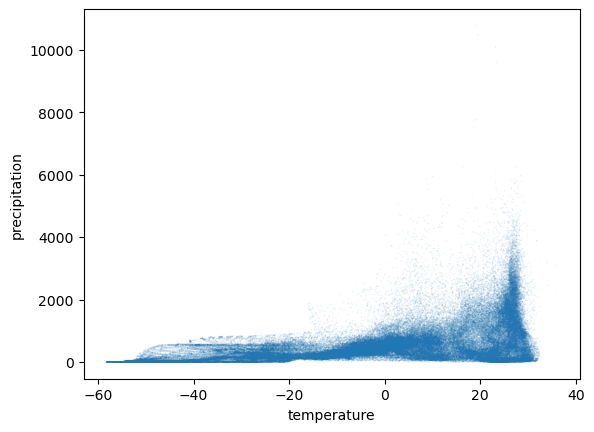

In [14]:
ds.plot.scatter(x="temperature", y="precipitation", s=1, alpha=0.1, edgecolor="none")

`facetting` is also supported here, by linking the `col` or `row` parameter to a data variable.

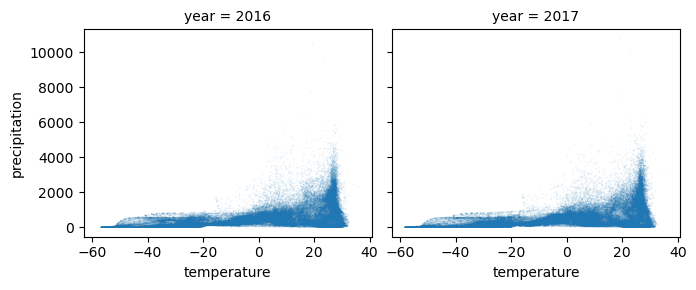

In [15]:
ds.plot.scatter(x="temperature", y="precipitation", s=1, alpha=0.1, col="year", edgecolor="none")  # try also hue="year" instead of col; requires hue_style="discrete"

### DataSet reductions

Datasets support arithmetic operations by automatically looping over all data variables and supports most of the same methods found on `xarray.DataArray`:

In [16]:
ds.mean()

<xarray.Dataset>
Dimensions:          ()
Data variables:
    precipitation    float32 536.7
    temperature      float32 -4.093
    precipitation_m  float32 0.5367

In [17]:
ds.max(dim=["x", "y"])

<xarray.Dataset>
Dimensions:          (year: 2)
Coordinates:
  * year             (year) int64 2016 2017
Data variables:
    precipitation    (year) float32 1.048e+04 1.077e+04
    temperature      (year) float32 36.1 35.8
    precipitation_m  (year) float32 10.48 10.77

__Note__ Using the names of the data variables (which is actually element-wise operations with DataArrays) makes a calculation very self-describing, e.g.

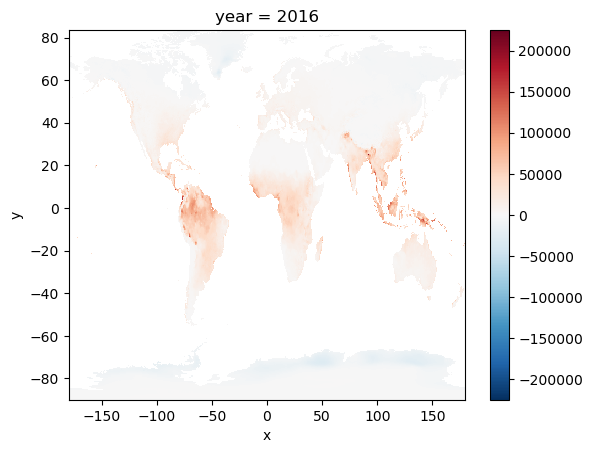

In [18]:
(ds["temperature"] * ds["precipitation"]).sel(year=2016).plot.imshow()

### Let's practice

For the next set of exercises, we use the [ERA5-Land monthly averaged data](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-land-monthly-means?tab=overview), provided by the ECMWF (European Centre for Medium-Range Weather Forecasts).

> ERA5-Land is a reanalysis dataset providing a consistent view of the evolution of land variables over several decades. Reanalysis combines model data with observations from across the world into a globally complete and consistent dataset using the laws of physics. 

For these exercises, a subset of the data set focusing on Belgium has been prepared, containing the following variables:

- `sf`: Snowfall (_m of water equivalent_)
- `sp`: Surface pressure (_Pa_)
- `t2m`: 2 metre temperature (_K_)
- `tp`: Total precipitation (_m_)
- `u10`: 10 metre U wind component (_m/s_)

The dimensions are the `longitude`, `latitude` and `time`, which are each represented by a corresponding coordinate.

In [19]:
era5 = xr.open_dataset("./data/era5-land-monthly-means_example.nc") # engine="netcdf4" is here optional
era5

<xarray.Dataset>
Dimensions:    (time: 486, latitude: 21, longitude: 38)
Coordinates:
  * time       (time) datetime64[ns] 1981-01-01 1981-02-01 ... 2021-06-01
  * latitude   (latitude) float64 51.5 51.4 51.3 51.2 ... 49.8 49.7 49.6 49.5
  * longitude  (longitude) float64 2.5 2.6 2.7 2.8 2.9 ... 5.8 5.9 6.0 6.1 6.2
Data variables:
    u10        (time, latitude, longitude) float32 ...
    t2m        (time, latitude, longitude) float32 ...
    sp         (time, latitude, longitude) float32 ...
    sf         (time, latitude, longitude) float32 ...
    tp         (time, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-09-27T16:23 GRIB to CDM+CF via cfgrib-0.9.9...

To get a feeling on the spatial subset of the data set for these exercises, the following code creates a cartopy map of the average temperature with country borders added:

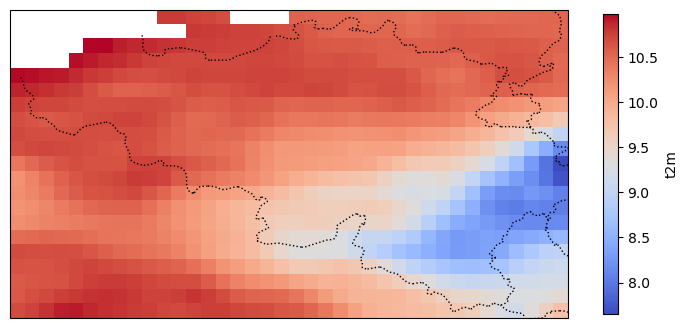

In [20]:
import cartopy
import cartopy.crs as ccrs

fig = plt.figure(figsize=(9,6))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
era5_mean_temp = era5["t2m"].mean(dim="time") - 273.15
era5_mean_temp.plot.imshow(ax=ax, cmap="coolwarm", 
                           transform=ccrs.PlateCarree(),
                           cbar_kwargs={'shrink': 0.65});

(See notebook [visualization-03-cartopy](./visualization-03-cartopy.ipynb) for more information on the usage of Cartopy)

<div class="alert alert-success">

**EXERCISE**:

The [short names used by ECMWF](https://confluence.ecmwf.int/display/CKB/ERA5-Land%3A+data+documentation) are not very convenient to understand. Rename the variables of the  data set according to the following mapping:
    
- `sf`: snowfall_m
- `sp`: pressure_pa
- `t2m`: temperature_k
- `tp`: precipitation_m
- `u10`: wind_ms   
    
Save the result of the mapping as the variable `era5_renamed`.

<details><summary>Hints</summary>

* Both `rename` and `rename_vars` can be used to rename the DataSet variables
* The `rename` function requires a `dict-like` input with the current names as the keys and the new names as the values. 

</details>    
    
</div>

In [21]:
mapping = {
    "sf": "snowfall_m",
    "sp": "pressure_pa",
    "t2m": "temperature_k",
    "tp": "precipitation_m",
    "u10": "wind_ms"
}

In [22]:
era5_renamed = era5.rename(mapping)
era5_renamed

<xarray.Dataset>
Dimensions:          (time: 486, latitude: 21, longitude: 38)
Coordinates:
  * time             (time) datetime64[ns] 1981-01-01 1981-02-01 ... 2021-06-01
  * latitude         (latitude) float64 51.5 51.4 51.3 51.2 ... 49.7 49.6 49.5
  * longitude        (longitude) float64 2.5 2.6 2.7 2.8 2.9 ... 5.9 6.0 6.1 6.2
Data variables:
    wind_ms          (time, latitude, longitude) float32 ...
    temperature_k    (time, latitude, longitude) float32 nan nan ... 291.5 291.7
    pressure_pa      (time, latitude, longitude) float32 ...
    snowfall_m       (time, latitude, longitude) float32 ...
    precipitation_m  (time, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-09-27T16:23 GRIB to CDM+CF via cfgrib-0.9.9...

__Note:__ _Make sure you have the variable `era5_renamed` correctly loaded for the following exercises. If not, load the solution of the previous exercise._

<div class="alert alert-success">

**EXERCISE**:

Start from the `era5_renamed` variable. You are used to work with temperatures defined in degrees celsius instead of Kelvin. Add a new data variable to `era5_renamed`, named `temperature_c`, by converting the `temperature_k` into degrees celsius:
    
$T_{^{\circ}C} = T_{K} - 273.15$
    
Create a histogram of the `temperature_c` to check the distribution of all the temperature valus in the data set. Use an appropriate number of bins to draw the histogram.

<details><summary>Hints</summary>

* Xarray - similar to Numpy - applies the mathematical operation element-wise, so no need for loops.
* Most plot functions work on `DataArray`, so make sure to select the variable to apply the `.plot.hist()`.
* One can define the number of bins using the `bins` parameter in the `hist` method.

</details>    
    
</div>

In [23]:
era5_renamed["temperature_c"] = era5_renamed["temperature_k"] - 273.15

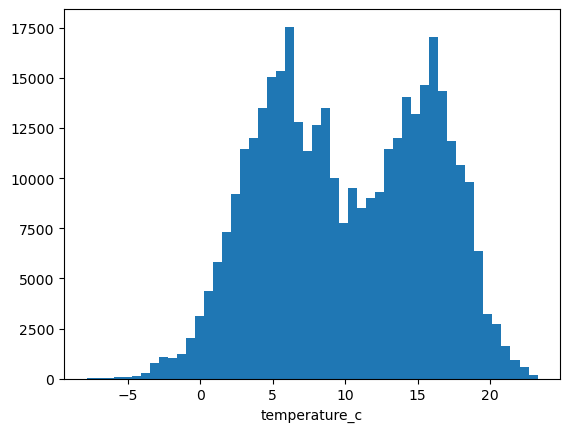

In [24]:
era5_renamed["temperature_c"].plot.hist(bins=50);

<div class="alert alert-success">

**EXERCISE**:

Calculate the total snowfall of the entire region of the dataset in function of time and create a line plot showing total snowfall in the y-axis and time in the x-axis.

<details><summary>Hints</summary>

* You need to calculate the total (`sum`) snowfall (`snowfall_m`) in function of time, i.e. aggregate over both the `longitude` and `latitude` dimensions (`dim=["latitude", "longitude"]`).
* As the result is a DataArray with a single dimension, the default `plot` will show a line, but you can be more explicit by saying `.plot.line()`.

</details>    
    
</div>

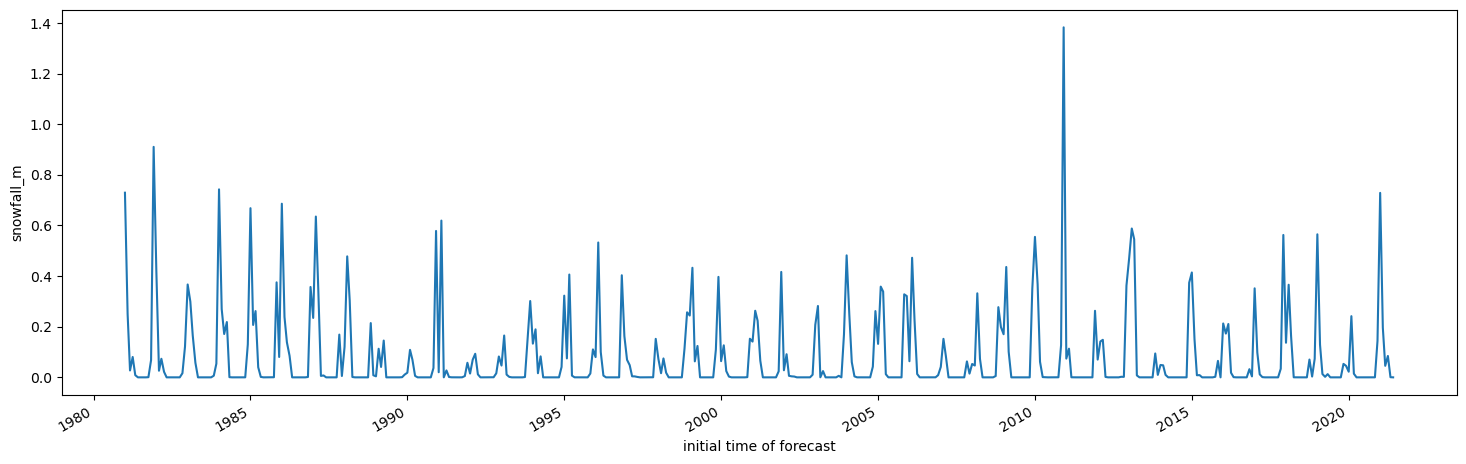

In [25]:
era5_renamed["snowfall_m"].sum(dim=["latitude", "longitude"]).plot.line(figsize=(18, 5))

<div class="alert alert-success">

**EXERCISE**:

The speed to sound is linearly dependent on temperature:
    
$v = 331.5 + (0.6 \cdot T)$
    
with $v$ the speed of sound and $T$ the temperature in degrees celsius.    
    
Add a new variable to the `era5_renamed` data set, called `speed_of_sound_m_s`, that calculates for each location and each time stamp in the data set the temperature corrected speed of sound.
    
Create a scatter plot to control the (linear) relationship you just calculated by comparing all the `speed_of_sound_m_s` and `temperature_c` data points in the data set.

<details><summary>Hints</summary>

* Creating a new variable is similar to GeoPandas/Pandas/dictionaries, `ds["MY_NEW_VAR"] = ...`.
* Remember, calculations are __element-wise__ just as in Numpy/Pandas; so no need for loops. The numbers (331.5, 0.6) are broadcasted to all elements in the data set to do the calculation.
* To compare two variables in a data set visually, `plot.scatter()` it is.

</details>    
    
</div>

In [26]:
era5_renamed["speed_of_sound_m_s"] = 331.5 + (0.6*era5_renamed["temperature_c"])

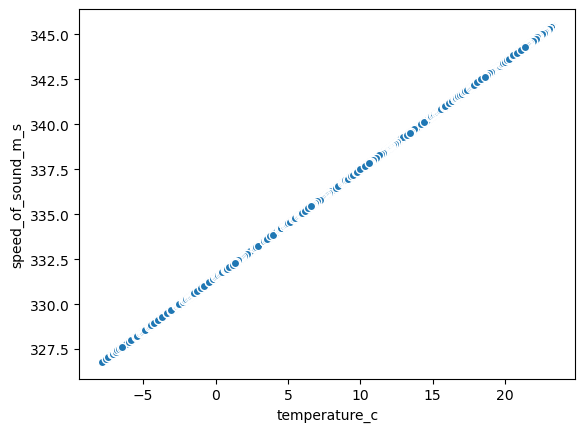

In [27]:
era5_renamed.plot.scatter(x="temperature_c", y="speed_of_sound_m_s")

## Working with time series

Let's start again from the ERA5 data set we worked with in the previous exercises, and rename the variables for convenience:

In [28]:
era5 = xr.open_dataset("./data/era5-land-monthly-means_example.nc")
mapping = {
    "sf": "snowfall_m",
    "sp": "pressure_pa",
    "t2m": "temperature_k",
    "tp": "precipitation_m",
    "u10": "wind_ms"
}
era5_renamed = era5.rename(mapping)
era5_renamed

<xarray.Dataset>
Dimensions:          (time: 486, latitude: 21, longitude: 38)
Coordinates:
  * time             (time) datetime64[ns] 1981-01-01 1981-02-01 ... 2021-06-01
  * latitude         (latitude) float64 51.5 51.4 51.3 51.2 ... 49.7 49.6 49.5
  * longitude        (longitude) float64 2.5 2.6 2.7 2.8 2.9 ... 5.9 6.0 6.1 6.2
Data variables:
    wind_ms          (time, latitude, longitude) float32 ...
    temperature_k    (time, latitude, longitude) float32 ...
    pressure_pa      (time, latitude, longitude) float32 ...
    snowfall_m       (time, latitude, longitude) float32 ...
    precipitation_m  (time, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-09-27T16:23 GRIB to CDM+CF via cfgrib-0.9.9...

Apart from the different coordinates, the data set also contains a `time` dimension. xarray borrows the indexing machinery from Pandas, also for datetime coordinates:

In [29]:
era5_renamed.time

<xarray.DataArray 'time' (time: 486)>
array(['1981-01-01T00:00:00.000000000', '1981-02-01T00:00:00.000000000',
       '1981-03-01T00:00:00.000000000', ..., '2021-04-01T00:00:00.000000000',
       '2021-05-01T00:00:00.000000000', '2021-06-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1981-01-01 1981-02-01 ... 2021-06-01
Attributes:
    long_name:      initial time of forecast
    standard_name:  forecast_reference_time

With a DateTime-aware index (see `datetime64[ns]` as dtype), selecting dates can be done using the string representation, e.g.

In [30]:
era5_renamed.sel(time="2002").time 

<xarray.DataArray 'time' (time: 12)>
array(['2002-01-01T00:00:00.000000000', '2002-02-01T00:00:00.000000000',
       '2002-03-01T00:00:00.000000000', '2002-04-01T00:00:00.000000000',
       '2002-05-01T00:00:00.000000000', '2002-06-01T00:00:00.000000000',
       '2002-07-01T00:00:00.000000000', '2002-08-01T00:00:00.000000000',
       '2002-09-01T00:00:00.000000000', '2002-10-01T00:00:00.000000000',
       '2002-11-01T00:00:00.000000000', '2002-12-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2002-01-01 2002-02-01 ... 2002-12-01
Attributes:
    long_name:      initial time of forecast
    standard_name:  forecast_reference_time

In [31]:
era5_renamed.sel(time=slice("2001-05", "2002-08")).time

<xarray.DataArray 'time' (time: 16)>
array(['2001-05-01T00:00:00.000000000', '2001-06-01T00:00:00.000000000',
       '2001-07-01T00:00:00.000000000', '2001-08-01T00:00:00.000000000',
       '2001-09-01T00:00:00.000000000', '2001-10-01T00:00:00.000000000',
       '2001-11-01T00:00:00.000000000', '2001-12-01T00:00:00.000000000',
       '2002-01-01T00:00:00.000000000', '2002-02-01T00:00:00.000000000',
       '2002-03-01T00:00:00.000000000', '2002-04-01T00:00:00.000000000',
       '2002-05-01T00:00:00.000000000', '2002-06-01T00:00:00.000000000',
       '2002-07-01T00:00:00.000000000', '2002-08-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2001-05-01 2001-06-01 ... 2002-08-01
Attributes:
    long_name:      initial time of forecast
    standard_name:  forecast_reference_time

And you can access the datetime components, e.g. "year", "month",..., "dayofyear", "week", "dayofweek",... but also "season". Do not forget to use the `.dt`-accessor to access these components:

In [32]:
era5_renamed["time"].dt.season

<xarray.DataArray 'season' (time: 486)>
array(['DJF', 'DJF', 'MAM', ..., 'MAM', 'MAM', 'JJA'], dtype=object)
Coordinates:
  * time     (time) datetime64[ns] 1981-01-01 1981-02-01 ... 2021-06-01
Attributes:
    long_name:      initial time of forecast
    standard_name:  forecast_reference_time

Xarray contains some more powerful functionalities to work with time series, e.g. `groupby`, `resample` and `rolling`. All have a similar syntax as Pandas/GeoPandas, but applied on an N-dimensional array instead of a DataFrame.

### split-apply-combine, aka `groupby`

If we are interested in the _average over time_ for each of the levels, we can use a reducton function to get the averages of each of the variables at the same time:

In [33]:
era5_renamed.mean(dim=["time"])

<xarray.Dataset>
Dimensions:          (latitude: 21, longitude: 38)
Coordinates:
  * latitude         (latitude) float64 51.5 51.4 51.3 51.2 ... 49.7 49.6 49.5
  * longitude        (longitude) float64 2.5 2.6 2.7 2.8 2.9 ... 5.9 6.0 6.1 6.2
Data variables:
    wind_ms          (latitude, longitude) float32 nan nan nan ... 0.677 0.6613
    temperature_k    (latitude, longitude) float32 nan nan nan ... 282.7 282.9
    pressure_pa      (latitude, longitude) float32 nan nan ... 9.874e+04
    snowfall_m       (latitude, longitude) float32 nan nan ... 0.0001283
    precipitation_m  (latitude, longitude) float32 nan nan ... 0.002439 0.002376

But if we wanted the _average for each month of the year_ per level, we would first have to __split__ the data set in a group for each month of the year, __apply__ the average function on each of the months and __combine__ the data again. 

We already learned about the [split-apply-combine](https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html) approach when using Pandas. The syntax of Xarray’s groupby is almost identical to Pandas!

First, extract the month of the year (1 -> 12) from each of the time coordinate/dimension:

In [34]:
era5_renamed["time"].dt.month  # The coordinates is a Pandas datetime index

<xarray.DataArray 'month' (time: 486)>
array([1, 2, 3, ..., 4, 5, 6])
Coordinates:
  * time     (time) datetime64[ns] 1981-01-01 1981-02-01 ... 2021-06-01
Attributes:
    long_name:      initial time of forecast
    standard_name:  forecast_reference_time

We can use this array in a `groupby` operation:

In [35]:
era5_renamed.groupby(era5_renamed["time"].dt.month)

DatasetGroupBy, grouped over 'month'
12 groups with labels 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12.

_split the data in (12) groups where each element is grouped according to the month it belongs to._

__Note:__ Xarray also offers a more concise syntax when the variable you're grouping on is already present in the dataset. The following statement is identical to the previous line:

In [36]:
era5_renamed.groupby("time.month")

DatasetGroupBy, grouped over 'month'
12 groups with labels 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12.

Next, we apply an aggregation function _for each of the months_ over the `time` dimension in order to end up with: _for each month of the year, the average (over time) for each of the levels_:

In [37]:
era5_renamed.groupby("time.month").mean()

<xarray.Dataset>
Dimensions:          (latitude: 21, longitude: 38, month: 12)
Coordinates:
  * latitude         (latitude) float64 51.5 51.4 51.3 51.2 ... 49.7 49.6 49.5
  * longitude        (longitude) float64 2.5 2.6 2.7 2.8 2.9 ... 5.9 6.0 6.1 6.2
  * month            (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    wind_ms          (month, latitude, longitude) float32 nan nan ... 0.9864
    temperature_k    (month, latitude, longitude) float32 nan nan ... 275.9
    pressure_pa      (month, latitude, longitude) float32 nan nan ... 9.88e+04
    snowfall_m       (month, latitude, longitude) float32 nan nan ... 0.0004173
    precipitation_m  (month, latitude, longitude) float32 nan nan ... 0.0029
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-09-27T16:23 GRIB to CDM+CF via cfgrib-0.9.9...

The resulting dimension month contains the 12 groups on which the data set was split up.

<img align="center" src="../img/pandas/06_groupby1.svg">

<div class="alert alert-info" style="font-size:120%">

**REMEMBER**: <br>

The `groupby` method splits the data set in groups, applies some function _on each of the groups_ and combines again the results of each of the groups. It is not limited to time series data, but can be used in any situation where the data can be split up by a categorical variable. 

</div>

### resample/rolling

Another (alike) operation - specifically for time series data - is to `resample` the data to another time-aggregation. For example, resample to monthly (`4M`) or yearly (`1Y`) median values:

In [38]:
era5_renamed.resample(time="1Y").median()  # 4M

<xarray.Dataset>
Dimensions:          (latitude: 21, longitude: 38, time: 41)
Coordinates:
  * latitude         (latitude) float64 51.5 51.4 51.3 51.2 ... 49.7 49.6 49.5
  * longitude        (longitude) float64 2.5 2.6 2.7 2.8 2.9 ... 5.9 6.0 6.1 6.2
  * time             (time) datetime64[ns] 1981-12-31 1982-12-31 ... 2021-12-31
Data variables:
    wind_ms          (time, latitude, longitude) float32 nan nan ... 0.5049
    temperature_k    (time, latitude, longitude) float32 nan nan ... 279.0 279.2
    pressure_pa      (time, latitude, longitude) float32 nan nan ... 9.882e+04
    snowfall_m       (time, latitude, longitude) float32 nan nan ... 6.312e-05
    precipitation_m  (time, latitude, longitude) float32 nan nan ... 0.002751
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-09-27T16:23 GRIB to CDM+CF via cfgrib-0.9.9...

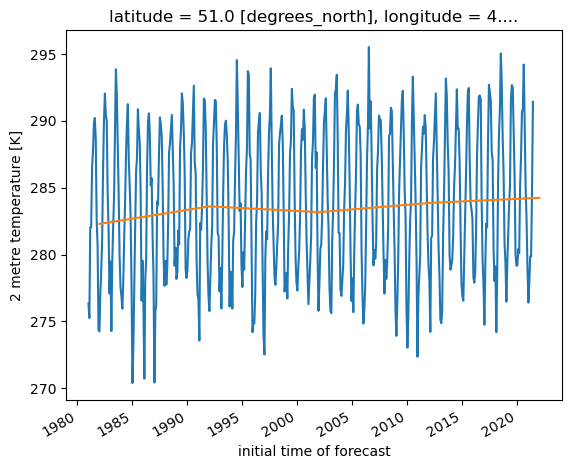

In [39]:
era5_renamed["temperature_k"].sel(latitude=51., longitude=4., method="nearest").plot.line(x="time");
era5_renamed["temperature_k"].sel(latitude=51., longitude=4., method="nearest").resample(time="10Y").median().plot.line(x="time");

A similar, but different functionality is `rolling` to calculate rolling window aggregates:

In [40]:
era5_renamed.rolling(time=12, center=True).median()

<xarray.Dataset>
Dimensions:          (time: 486, latitude: 21, longitude: 38)
Coordinates:
  * time             (time) datetime64[ns] 1981-01-01 1981-02-01 ... 2021-06-01
  * latitude         (latitude) float64 51.5 51.4 51.3 51.2 ... 49.7 49.6 49.5
  * longitude        (longitude) float64 2.5 2.6 2.7 2.8 2.9 ... 5.9 6.0 6.1 6.2
Data variables:
    wind_ms          (time, latitude, longitude) float32 nan nan nan ... nan nan
    temperature_k    (time, latitude, longitude) float32 nan nan nan ... nan nan
    pressure_pa      (time, latitude, longitude) float32 nan nan nan ... nan nan
    snowfall_m       (time, latitude, longitude) float32 nan nan nan ... nan nan
    precipitation_m  (time, latitude, longitude) float32 nan nan nan ... nan nan
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-09-27T16:23 GRIB to CDM+CF via cfgrib-0.9.9...

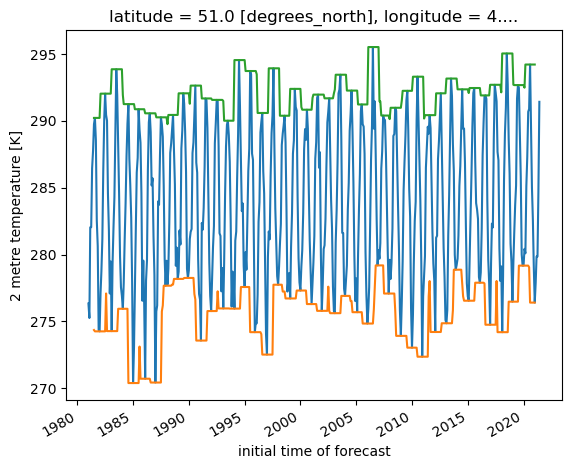

In [41]:
era5_renamed["temperature_k"].sel(latitude=51., longitude=4., method="nearest").plot.line()
era5_renamed["temperature_k"].sel(latitude=51., longitude=4., method="nearest").rolling(time=12, center=True).min().plot.line()
era5_renamed["temperature_k"].sel(latitude=51., longitude=4., method="nearest").rolling(time=12, center=True).max().plot.line()

<div class="alert alert-info" style="font-size:120%">

**REMEMBER**: <br>

The [xarray `groupby`](http://xarray.pydata.org/en/stable/groupby.html) with the same syntax as Pandas implements the __split-apply-combine__ strategy. Also [`resample`](http://xarray.pydata.org/en/stable/time-series.html#resampling-and-grouped-operations) and [`rolling`](http://xarray.pydata.org/en/stable/computation.html?highlight=rolling#rolling-window-operations) are available in xarray.
    
__Note:__ Xarray adds a [`groupby_bins`](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.groupby_bins.html#xarray.Dataset.groupby_bins) convenience function for binned groups (instead of each value).

</div>

### Let's practice

Run this cell before doing the exercises, so the starting point is again the `era5_renamed` data set:

In [42]:
era5 = xr.open_dataset("./data/era5-land-monthly-means_example.nc")
mapping = {
    "sf": "snowfall_m",
    "sp": "pressure_pa",
    "t2m": "temperature_k",
    "tp": "precipitation_m",
    "u10": "wind_ms"
}
era5_renamed = era5.rename(mapping)

<div class="alert alert-success">

**EXERCISE**:

Select the pressure data for the pixel closest to the center of Ghent (lat: -51.05, lon: 3.71) and assign the outcome to a new variable `ghent_pressure`.

Define a Matplotlib `Figure` and `Axes` (respectively named `fig, ax`) and use it to create a plot that combines the yearly average of the pressure data in Gent with the monthly pressure data as function of time for that same pixel as line plots. Change the name of the y-label to `'Pressure (Pa)'` and the title of the plot to `'Pressure (Pa) in Ghent (at -51.05, 3.71)'` (see notebook [visualization-01-matplotlib.ipynb](./visualization-01-matplotlib.ipynb#An-small-cheat-sheet-reference-for-some-common-elements) for more information)

<details><summary>Hints</summary>
    
* For the yearly average, actually both `resample(time="Y")` as `groupby("time.year")` can be used. The main difference is the returned dimension after the grouping: `resample` returns a DateTimeIndex, whereas `groupby` returns a dimension called `year` and no longer contains the DateTimeIndex. To combine the data with other time series data, using the DateTimeIndex is preferred (i.e. `resample`). 
* `fig, ax = plt.subplots()` is a useful shortcut to prepare a Matplotlib Figure. You can add a label `set_label()` and title `set_title()` to the `axes` object.

</details>    
    
</div>

Text(0.5, 1.0, 'Pressure (Pa) in Ghent (-51.05, 3.71)')

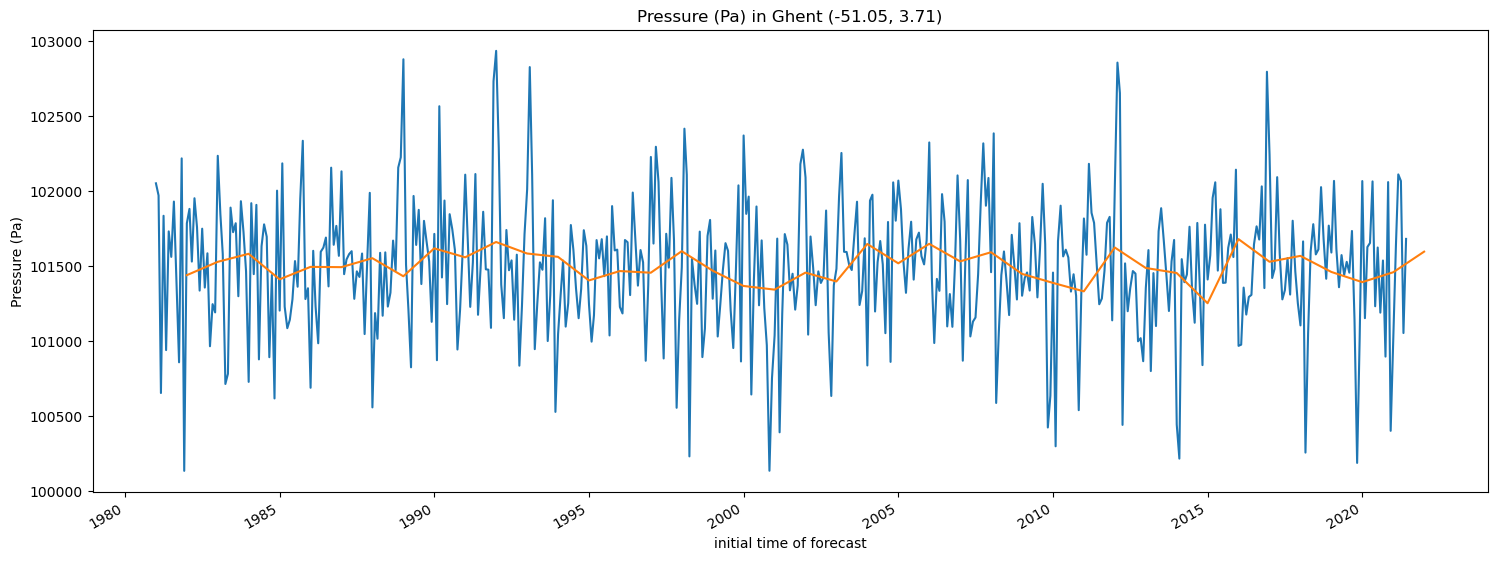

In [43]:
ghent_pressure = era5_renamed.sel(latitude=51.05, longitude=3.71, method="nearest")["pressure_pa"]

fig, ax = plt.subplots(figsize=(18, 6))
ghent_pressure.plot.line(ax=ax)
ghent_pressure.resample(time="Y").mean().plot.line(ax=ax)

ax.set_ylabel('Pressure (Pa)')
ax.set_title('Pressure (Pa) in Ghent (-51.05, 3.71)')

<div class="alert alert-success">

**EXERCISE**:
    
Select the precipitation data for the pixel closest to the center of Ghent (lat: -51.05, lon: 3.71) and assign the outcome to a new variable `ghent_precipitation`.
    
For the Ghent pixel, calculate the maximal precipitation _for each month of the year_ (1 -> 12) and convert it to mm precipitation.
    
To make a bar-chart (not supported in xarray) of the maximal precipitation for each month of the year, convert the output to a Pandas DataFrame using the `to_dataframe()` method and create a horizontal bar chart with the month in the y-axis and the maximal precipitation in the x-axis. Feel free to improve the axis labels.

<details><summary>Hints</summary>
    
* You need to group based on the month of the data point, hence `groupby("...")` with `time` as an existing dimension, the `time.month` shortcut to get the corresponding month will work.
* Plotting in Pandas is very similar to xarray, use `.plot.barh()` to create a horizontal bar chart.

</details>    
    
</div>

Text(0, 0.5, 'Month of the year')

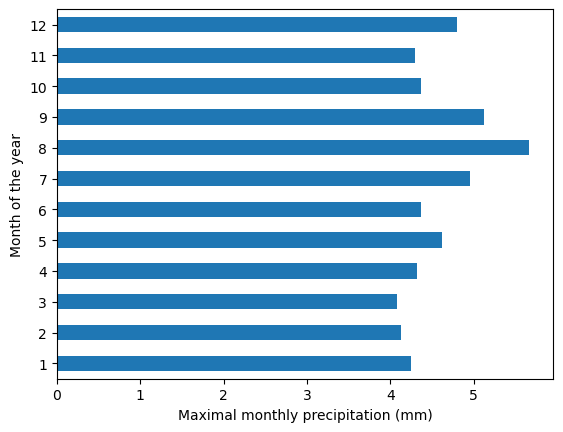

In [44]:
ghent_precipitation = era5_renamed.sel(latitude=51.05, longitude=3.71, method="nearest")["precipitation_m"]
ghent_precipitation_month_max = ghent_precipitation.groupby("time.month").max()*1000

fig, ax = plt.subplots()
ghent_precipitation_month_max.to_dataframe()["precipitation_m"].plot.barh(ax=ax)
ax.set_xlabel("Maximal monthly precipitation (mm)")
ax.set_ylabel("Month of the year")

<div class="alert alert-success">

**EXERCISE**:
    
Calculate the pixel-based average temperature _for each season_. Make a plot (`imshow`) with each of the seasons in a separate subplot next to each other. 

<details><summary>Hints</summary>
    
* You need to group based on the season of the data point, hence `groupby("...")` with `time` as an existing dimension, the `time.season` shortcut to get the corresponding season will work.
* The labels of the season groups are sorted on the strings in the description instead of the seasons. The workaround is to `sortby` and provide a correctly sorted version to sort the `season` with, see the open issue https://github.com/pydata/xarray/issues/757.
* Use facetting to plot each of the seasons next to each other, with `col="season"`.


</details>    
    
</div>

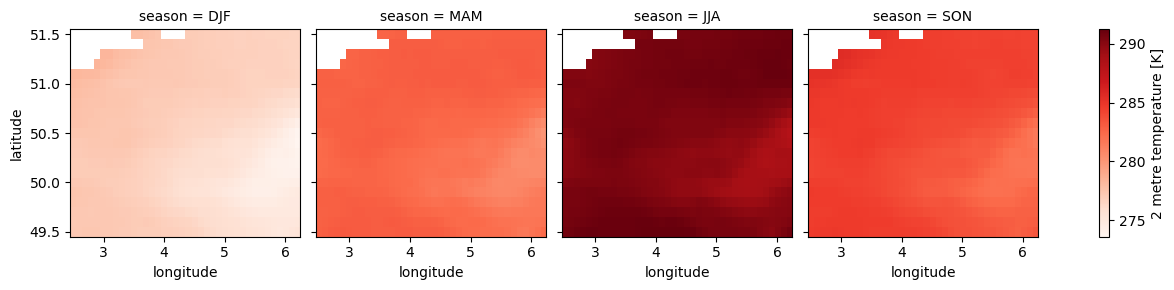

In [45]:
seaons_temp = era5_renamed["temperature_k"].groupby("time.season").mean()
# See https://github.com/pydata/xarray/issues/757 for getting well-sorted groups for plotting
seaons_temp = seaons_temp.sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'], dims=['season']))
seaons_temp.plot.imshow(col="season", cmap="Reds")

<div class="alert alert-success">

**EXERCISE**:

Calculate the average temperature of the entire region of the dataset in function of time. From this time series, use only those years for which all 12 months of the year are included in the data set and calculate the yearly average temperature.
    
Create a line plot showing the yearly average temperature in the y-axis and time in the x-axis.

<details><summary>Hints</summary>

* You need to calculate the average (`mean`) temperature in function of time, i.e. aggregate over both the `longitude` and `latitude` dimensions.
* Year 2021 is only available till June, so exclude the year (e.g. slice till 2020).
* Resample to yearly values.
* As the result is a DataArray with a single dimension, the default `plot` will show a line, but you can be more explicit by saying `.plot.line()`.

</details>    
    
</div>

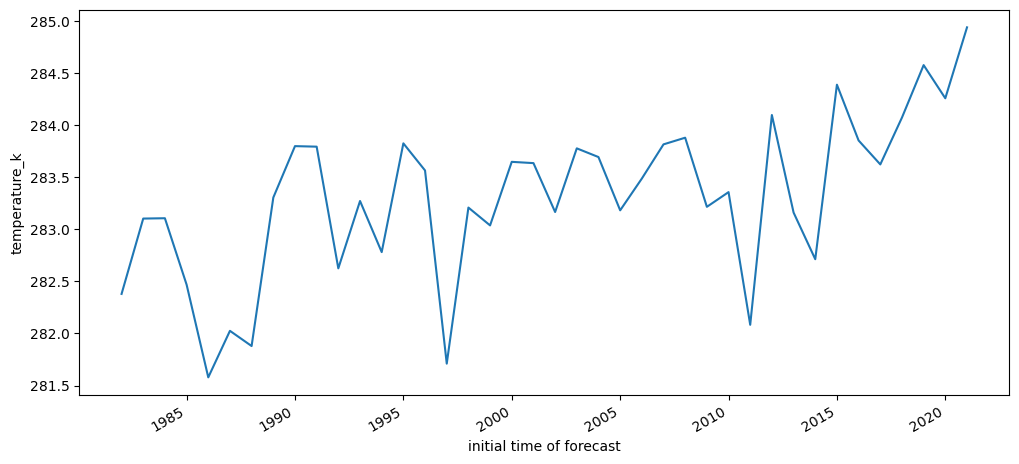

In [46]:
temp_mean = era5_renamed["temperature_k"].mean(dim=["latitude", "longitude"]).sel(time=slice("1981", "2020"))
temp_mean.resample(time="Y").mean().plot.line(figsize=(12, 5))

<div class="alert alert-success">

**EXERCISE**:
    
Create the yearly total snowfall from 1991 up to 2005 and convert the snowfall into cm.  Make a plot (`imshow`) with each of the individual years in a separate subplot divided into 3 rows and 5 columns.
    
Make sure to update the name of the snowfall variable and/or colorbar label to make sure it defines the unit in cm.
 

<details><summary>Hints</summary>

* When selecting time series data from a coordinate with datetime-aware data, one can use strings to define a date. In combination with `slice`, the selection of the required years becomes `slice("1991", "2005")`.
* From montly to yearly data is a `resample` of the data.
* Use `.rename(NEW_NAME)` to update the name of a `DataArray`
* xarray supports _facetting_ directly, check out the `col` and `col_wrap` parameters in the plot functions of xarray or check http://xarray.pydata.org/en/stable/user-guide/plotting.html#faceting.
* To update the colorbar unit use, the `cbar_kwargs` option.

</details>    
    
</div>

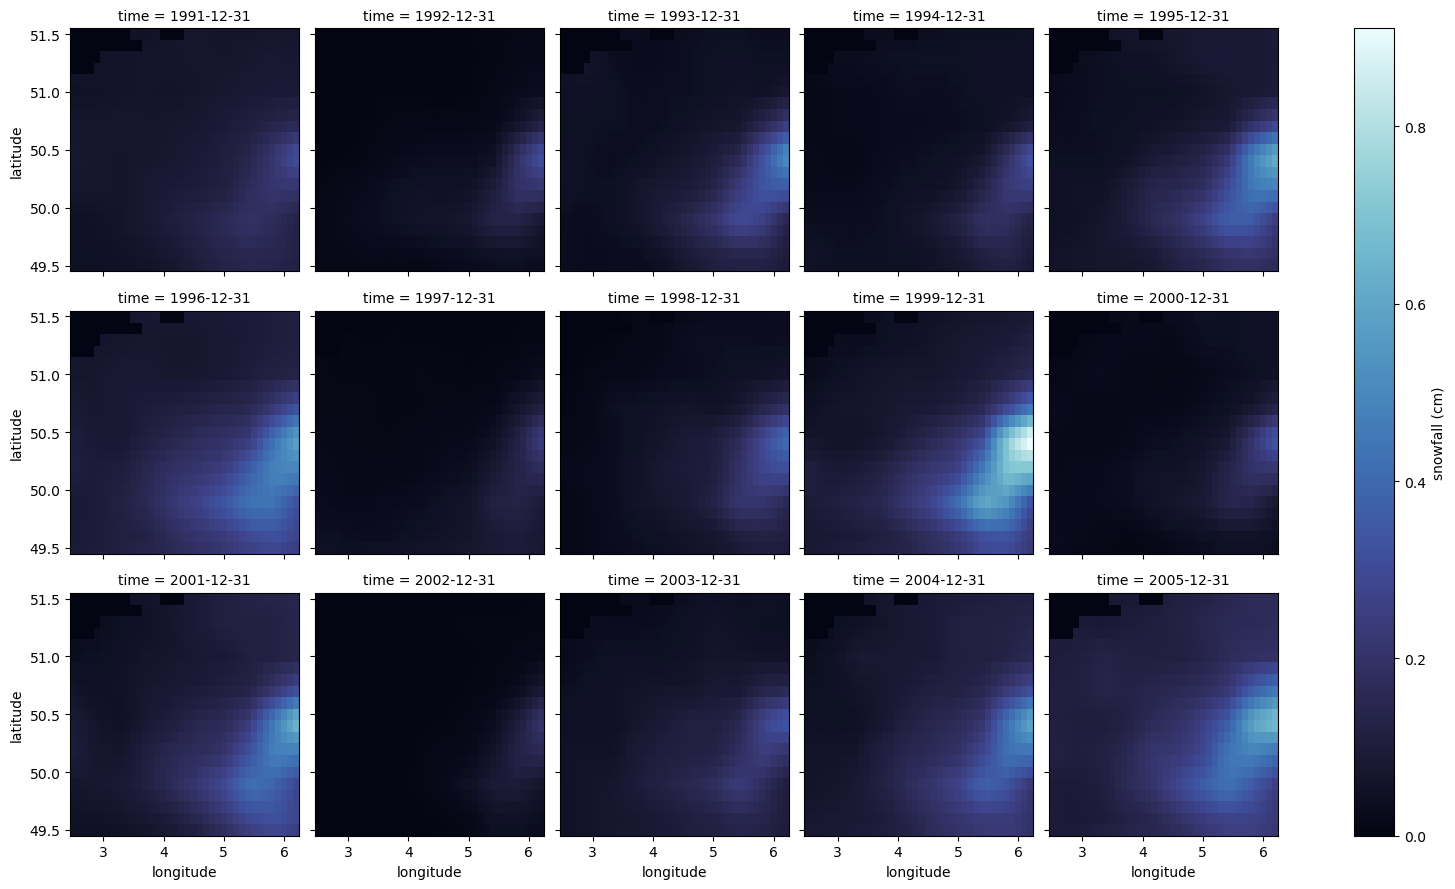

In [47]:
snowfall_1991_2005 = era5_renamed.sel(time=slice("1991", "2005"))["snowfall_m"]
snowfall_yearly = snowfall_1991_2005.resample(time="Y").sum()*100
snowfall_yearly = snowfall_yearly.rename("snowfall_cm")
snowfall_yearly.plot.imshow(col="time", col_wrap=5, cmap=cmocean.cm.ice, 
                            cbar_kwargs={"label": "snowfall (cm)"})

## xarray lazy data loading

Values are only read from disk when needed. For example, the following statement only reads the coordinate information and the metadata. The data itself is not yet loaded:

In [48]:
data_file = "./data/2016-2017_global_rain-temperature.nc"

In [49]:
ds = xr.open_dataset(data_file)

`load()` will explicitly load the data into memory:

In [50]:
xr.open_dataset(data_file).load()

<xarray.Dataset>
Dimensions:        (y: 347, x: 720, year: 2)
Coordinates:
  * y              (y) float64 83.25 82.75 82.25 81.75 ... -88.75 -89.25 -89.75
  * x              (x) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * year           (year) int64 2016 2017
Data variables:
    precipitation  (year, y, x) float32 nan nan nan nan nan ... 0.8 0.8 0.8 0.8
    temperature    (year, y, x) float32 nan nan nan nan ... -47.9 -47.9 -47.9

## (Optional) From DataSet to DataArray and back

Consider the sentinel images of Gent used in a previous notebook:

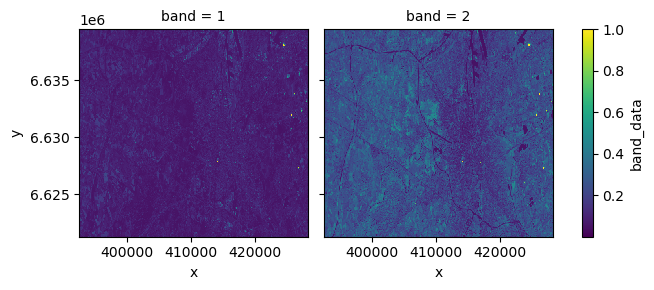

In [51]:
gent_file = "./data/gent/raster/2020-09-17_Sentinel_2_L1C_B0408.tiff"
gent_array = xr.open_dataarray(gent_file, engine="rasterio")
gent_array.plot.imshow(col="band")

The data is a `xarray.DataArray` with 3 dimensions and corresponding coordinates. Assigning the names `b4` and `b8` to the individual bands, makes the data more self-describing:

In [52]:
gent_array = gent_array.assign_coords(band=("band", ["b4", "b8"]))
gent_array

<xarray.DataArray 'band_data' (band: 2, y: 317, x: 625)>
array([[[0.078202, 0.088396, ..., 0.104005, 0.086397],
        [0.102205, 0.075898, ..., 0.065705, 0.065507],
        ...,
        [0.070298, 0.069505, ..., 0.089006, 0.059907],
        [0.070603, 0.0748  , ..., 0.067597, 0.082994]],

       [[0.273594, 0.256992, ..., 0.245197, 0.232105],
        [0.255695, 0.231998, ..., 0.223301, 0.231006],
        ...,
        [0.2822  , 0.2925  , ..., 0.262196, 0.379797],
        [0.288502, 0.248096, ..., 0.338796, 0.372198]]])
Coordinates:
  * band         (band) <U2 'b4' 'b8'
  * x            (x) float64 3.925e+05 3.926e+05 ... 4.282e+05 4.283e+05
  * y            (y) float64 6.639e+06 6.639e+06 ... 6.621e+06 6.621e+06
    spatial_ref  int64 ...
Attributes:
    AREA_OR_POINT:  Area

In case one wants to work with the different bands as DataSet variables instead of a dimension of a single DataArray, the conversion `to_dataset` can be done, defining the dimension to convert to data set variables, e.g.

In [53]:
gent_ds = gent_array.to_dataset(dim="band")
gent_ds

<xarray.Dataset>
Dimensions:      (y: 317, x: 625)
Coordinates:
  * x            (x) float64 3.925e+05 3.926e+05 ... 4.282e+05 4.283e+05
  * y            (y) float64 6.639e+06 6.639e+06 ... 6.621e+06 6.621e+06
    spatial_ref  int64 ...
Data variables:
    b4           (y, x) float64 0.0782 0.0884 0.1751 ... 0.05769 0.0676 0.08299
    b8           (y, x) float64 0.2736 0.257 0.2479 ... 0.3324 0.3388 0.3722
Attributes:
    AREA_OR_POINT:  Area

Consider the calculation of the NDVI for Gent using a xarray DataArray:

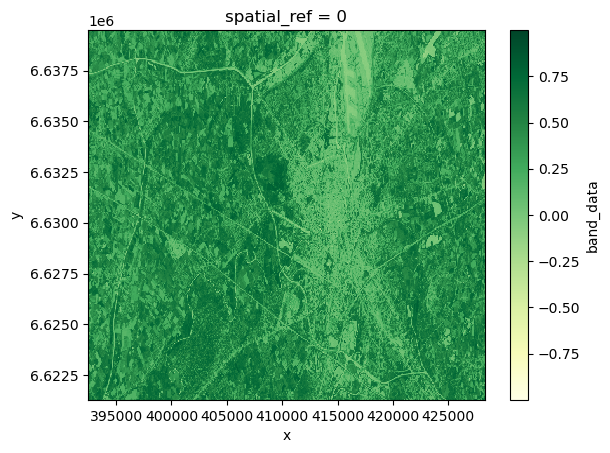

In [54]:
ndvi_array = (gent_array.sel(band="b8") - gent_array.sel(band="b4"))/(gent_array.sel(band="b8") + gent_array.sel(band="b4"))
ndvi_array.plot.imshow(cmap="YlGn")

One might find the usage of data variable in this case more convenient, as it provides the ability to:

1. work with the variable names directly
2. Add the output tot the data set as a new variable
3. The output can be converted to an Array again using `to_array`

For example:

In [55]:
gent_ds["ndvi"] = (gent_ds["b8"] - gent_ds["b4"])/(gent_ds["b8"] + gent_ds["b4"])
gent_ds.to_array(dim="layer")

<xarray.DataArray (layer: 3, y: 317, x: 625)>
array([[[0.07820249, 0.08839551, 0.17509728, ..., 0.10339513,
         0.10400549, 0.08639658],
        [0.10220493, 0.07589837, 0.0854963 , ..., 0.07319753,
         0.06570535, 0.06550698],
        [0.10110628, 0.08000305, 0.07699702, ..., 0.06880293,
         0.07330434, 0.07049668],
        ...,
        [0.07269398, 0.07420462, 0.06810101, ..., 0.14090181,
         0.1008011 , 0.06829938],
        [0.07029831, 0.06950484, 0.06720073, ..., 0.0733959 ,
         0.08900587, 0.05990692],
        [0.07060349, 0.07479973, 0.07240406, ..., 0.05769436,
         0.06759747, 0.08299382]],

       [[0.27359426, 0.25699245, 0.24789807, ..., 0.28369574,
         0.24519722, 0.23210498],
        [0.25569543, 0.23199817, 0.25969329, ..., 0.25510033,
         0.22330053, 0.23100633],
        [0.22659648, 0.24240482, 0.26790265, ..., 0.2717937 ,
         0.28119326, 0.30969711],
...
        [0.2695964 , 0.25340658, 0.29199664, ..., 0.24559396,
         0.29170672, 0.30899519],
        [0.28220035, 0.29250019, 0.29359884, ..., 0.21399252,
         0.26219577, 0.37979706],
        [0.28850233, 0.24809644, 0.26190585, ..., 0.33240253,
         0.33879606, 0.37219806]],

       [[0.55541097, 0.48813784, 0.17210779, ..., 0.46578366,
         0.40432598, 0.45748096],
        [0.42886378, 0.50698781, 0.5046415 , ..., 0.55407855,
         0.54530095, 0.5581515 ],
        [0.38293909, 0.50371527, 0.5535106 , ..., 0.59598584,
         0.58643251, 0.62915396],
        ...,
        [0.57524964, 0.54699581, 0.62176363, ..., 0.27087528,
         0.48637406, 0.63795195],
        [0.60114281, 0.61600067, 0.62748996, ..., 0.48922162,
         0.49313521, 0.72751249],
        [0.60678168, 0.53669486, 0.56684468, ..., 0.70420497,
         0.66733   , 0.63534578]]])
Coordinates:
  * x            (x) float64 3.925e+05 3.926e+05 ... 4.282e+05 4.283e+05
  * y            (y) float64 6.639e+06 6.639e+06 ... 6.621e+06 6.621e+06
    spatial_ref  int64 ...
  * layer        (layer) object 'b4' 'b8' 'ndvi'
Attributes:
    AREA_OR_POINT:  Area